<a href="https://colab.research.google.com/github/LeNguyenBaoTran/B2110033/blob/main/search_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision faiss-cpu pillow timm ftfy regex tqdm opencv-python clip --quiet

import os
import numpy as np
import torch
from PIL import Image
import faiss
from google.colab import files
import pandas as pd
import shutil
from sklearn.cluster import KMeans
import clip
import matplotlib.pyplot as plt

# --- Device ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.3 MB/s eta 0:00:00
Using device: cuda


In [ ]:
# --- Upload CSV ---
uploaded = files.upload()  # chọn anh_san_pham.csv và san_pham.csv
df_anh = pd.read_csv("anh_san_pham.csv")
df_sanpham = pd.read_csv("san_pham.csv")

print(df_anh.head())
print(df_sanpham.head())

Saving san_pham.csv to san_pham.csv
Saving anh_san_pham.csv to anh_san_pham.csv
   ANH_MA                                 ANH_DUONGDAN  SP_MA
0       1    ../assets/images/ao_somi_nam_xanh_doc.png      1
1       2  ../assets/images/ao_somi_nam_xanh_doc_1.png      1
2       3  ../assets/images/ao_somi_nam_xanh_doc_2.png      1
3       4  ../assets/images/ao_somi_nam_xanh_doc_3.png      1
4       5  ../assets/images/ao_somi_nam_xanh_doc_4.png      1
   SP_MA                               SP_TEN SP_CHATLIEU  \
0      1        Áo Sơ Mi Nam Dài Tay Xanh Sọc      Cotton   
1      2      Áo Sơ Mi Nam Dài Tay Trắng Trơn      Cotton   
2      3       Áo Sơ Mi Nam Dài Tay Xanh Navy       Linen   
3      4        Áo Sơ Mi Nam Dài Tay Xám Trơn      Cotton   
4      5  Áo Sơ Mi Nam Dài Tay Trắng Thêu Chữ   Polyester   

                                             SP_MOTA          SP_NGAYTHEM  \
0  Áo sơ mi nam dài tay kẻ sọc xanh mang đến phon...  2025-09-22 22:42:53   
1   Áo sơ mi nam dài tay tr

In [ ]:
# --- Upload Images ---
os.makedirs("images", exist_ok=True)
uploaded_images = files.upload()  # chọn tất cả ảnh sản phẩm
for filename in uploaded_images.keys():
    shutil.move(filename, os.path.join("images", filename))
print("Uploaded images:", os.listdir("images")[:10])


Saving anhbia.png to anhbia.png
Saving anhbia1.png to anhbia1.png
Saving anhbia2.png to anhbia2.png
Saving anhbia3.png to anhbia3.png
Saving anhbia4.png to anhbia4.png
Saving anhbia5.png to anhbia5.png
Saving anhdau1.png to anhdau1.png
Saving anhdau2.png to anhdau2.png
Saving anhdau3.png to anhdau3.png
Saving anhdau4.png to anhdau4.png
Saving anhdau5.png to anhdau5.png
Saving anhdau6.png to anhdau6.png
Saving anhdau7.png to anhdau7.png
Saving anhdau8.png to anhdau8.png
Saving anhdau9.png to anhdau9.png
Saving anhdau10.png to anhdau10.png
Saving anhdau11.png to anhdau11.png
Saving anhdau12.png to anhdau12.png
Saving anhdau13.png to anhdau13.png
Saving anhdau14.png to anhdau14.png
Saving anhdau15.png to anhdau15.png
Saving ao_jacket_nam_den.png to ao_jacket_nam_den.png
Saving ao_jacket_nam_den_1.png to ao_jacket_nam_den_1.png
Saving ao_jacket_nam_den_2.png to ao_jacket_nam_den_2.png
Saving ao_jacket_nam_den_3.png to ao_jacket_nam_den_3.png
Saving ao_jacket_nam_den_4.png to ao_jacket_nam_

In [ ]:
# --- Tạo cột path ảnh đầy đủ ---
def get_correct_image_path(filepath):
    filename = os.path.basename(filepath)
    path_png = os.path.join("images", filename.replace('.PNG', '.png'))
    path_PNG = os.path.join("images", filename.replace('.png', '.PNG'))
    path_jpg = os.path.join("images", filename.replace('.JPG', '.jpg'))
    path_JPG = os.path.join("images", filename.replace('.jpg', '.JPG'))
    base_path = os.path.join("images", filename)
    for p in [base_path, path_png, path_PNG, path_jpg, path_JPG]:
        if os.path.exists(p):
            return p
    print(f"Warning: {filename} not found")
    return None

df_anh['ANH_DUONGDAN_FULL'] = df_anh['ANH_DUONGDAN'].apply(get_correct_image_path)
df_anh.dropna(subset=['ANH_DUONGDAN_FULL'], inplace=True)


In [ ]:
# --- Mapping SP_MA -> ảnh đại diện ---
product_id_to_representative_image = {}
for sp_id, group in df_anh.groupby("SP_MA"):
    product_id_to_representative_image[sp_id] = group['ANH_DUONGDAN_FULL'].iloc[0]

print(f"Found {len(product_id_to_representative_image)} products")

Found 144 products


In [ ]:
!pip uninstall open_clip_torch -y
!pip install open_clip_torch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 34.2 MB/s eta 0:00:00


In [ ]:
!pip install open_clip_torch --quiet

In [ ]:
!pip install open_clip_torch --quiet
import open_clip
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# --- Tạo model và hàm tiền xử lý ---
clip_model, _, clip_preprocess = open_clip.create_model_and_transforms(
    model_name='ViT-B-32',
    pretrained='openai'
)
clip_model = clip_model.to(device)
clip_model.eval()


Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import cv2
from PIL import Image

# --- Hàm lấy embedding CLIP ---
def get_clip_embedding(image_path):
    img = clip_preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = clip_model.encode_image(img)
        emb /= emb.norm(dim=-1, keepdim=True)
    return emb.cpu().numpy()[0]

# --- Hàm lấy màu chủ đạo ---
def get_dominant_color(image_path, k=3):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.reshape((-1, 3))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(img)
    counts = np.bincount(kmeans.labels_)
    dominant_color = kmeans.cluster_centers_[np.argmax(counts)]
    dominant_color = dominant_color / 255.0  # normalize 0-1
    return dominant_color


In [ ]:
import faiss

image_paths = df_anh['ANH_DUONGDAN_FULL'].tolist()
product_ids = df_anh['SP_MA'].tolist()

combined_embeddings = []
for path in image_paths:
    clip_emb = get_clip_embedding(path)
    color_emb = get_dominant_color(path)
    combined_emb = np.concatenate([clip_emb, color_emb]).astype('float32')
    combined_embeddings.append(combined_emb)

combined_embeddings = np.array(combined_embeddings)
faiss.normalize_L2(combined_embeddings)

index = faiss.IndexFlatIP(combined_embeddings.shape[1])
index.add(combined_embeddings)
print("✅ FAISS index built successfully!")
print("Number of vectors:", index.ntotal)


✅ FAISS index built successfully!
Number of vectors: 696


In [ ]:
# --- Lưu mô hình đã huấn luyện ---
import numpy as np
import faiss

# Tạo thư mục lưu mô hình (nếu chưa có)
os.makedirs("saved_model", exist_ok=True)

# Lưu chỉ mục FAISS
faiss.write_index(index, "saved_model/index.faiss")

# Lưu danh sách product_id và đường dẫn ảnh
np.save("saved_model/product_ids.npy", np.array(product_ids))
np.save("saved_model/image_paths.npy", np.array(image_paths))

print("🎯 Đã lưu mô hình thành công vào thư mục saved_model/")


🎯 Đã lưu mô hình thành công vào thư mục saved_model/


In [ ]:
from google.colab import files

files.download("saved_model/index.faiss")
files.download("saved_model/product_ids.npy")
files.download("saved_model/image_paths.npy")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
uploaded_query = files.upload()  # chọn ảnh truy vấn
query_image_path = list(uploaded_query.keys())[0]

def search_similar_products(query_image_path, top_k=5):
    clip_emb = get_clip_embedding(query_image_path)
    color_emb = get_dominant_color(query_image_path)
    query_emb = np.concatenate([clip_emb, color_emb]).astype('float32').reshape(1, -1)
    faiss.normalize_L2(query_emb)
    distances, indices = index.search(query_emb, top_k)

    results = []
    for i in indices[0]:
        sp_id = product_ids[i]
        img_path = product_id_to_representative_image[sp_id]
        results.append((sp_id, img_path))
    return results

results = search_similar_products(query_image_path, top_k=5)


Saving 7.jpg to 7.jpg


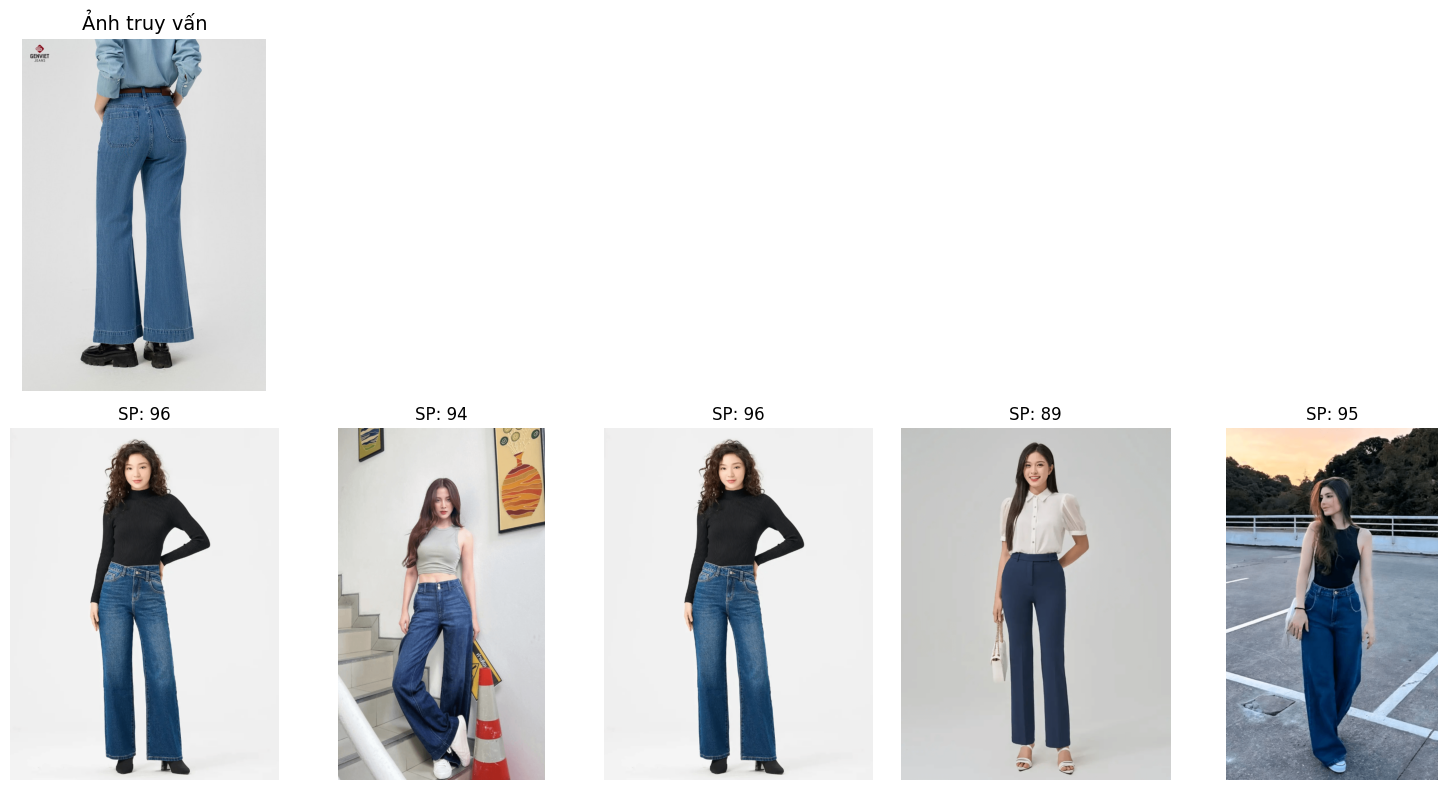

In [ ]:
# --- Hiển thị ảnh theo style đẹp như demo ---
import matplotlib.pyplot as plt
from PIL import Image

def show_results(query_image_path, results):
    top_k = len(results)
    plt.figure(figsize=(15, 8))

    # --- Hiển thị ảnh truy vấn ---
    plt.subplot(2, top_k, 1)
    plt.imshow(Image.open(query_image_path))
    plt.axis('off')
    plt.title("Ảnh truy vấn", fontsize=14)

    # --- Hiển thị ảnh kết quả ---
    for i, (sp_id, img_path) in enumerate(results):
        plt.subplot(2, top_k, top_k + i + 1)
        plt.imshow(Image.open(img_path))
        plt.axis('off')
        plt.title(f"SP: {sp_id}", fontsize=12)

    plt.tight_layout()
    plt.show()


show_results(query_image_path, results)

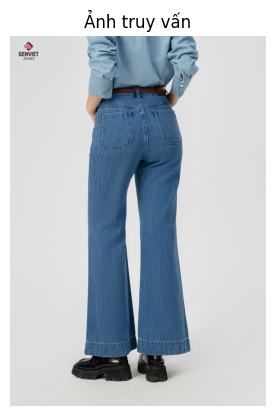

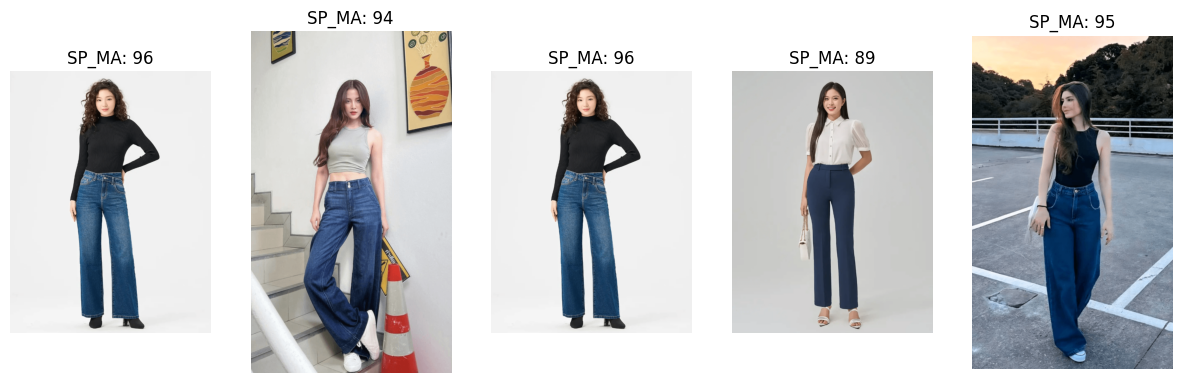

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(Image.open(query_image_path))
plt.axis('off')
plt.title("Ảnh truy vấn")
plt.show()

plt.figure(figsize=(15,5))
for i, (sp_id, img_path) in enumerate(results):
    plt.subplot(1,5,i+1)
    plt.imshow(Image.open(img_path))
    plt.axis('off')
    plt.title(f"SP_MA: {sp_id}")
plt.show()


In [ ]:
uploaded_query = files.upload()  # chọn ảnh truy vấn
query_image_path = list(uploaded_query.keys())[0]

def search_similar_products(query_image_path, top_k=5):
    clip_emb = get_clip_embedding(query_image_path)
    color_emb = get_dominant_color(query_image_path)
    query_emb = np.concatenate([clip_emb, color_emb]).astype('float32').reshape(1, -1)
    faiss.normalize_L2(query_emb)
    distances, indices = index.search(query_emb, top_k)

    results = []
    for i in indices[0]:
        sp_id = product_ids[i]
        img_path = product_id_to_representative_image[sp_id]
        results.append((sp_id, img_path))
    return results

results = search_similar_products(query_image_path, top_k=5)

Saving 6.jpg to 6.jpg


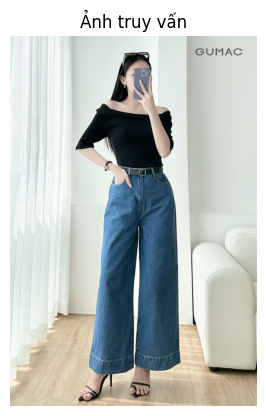

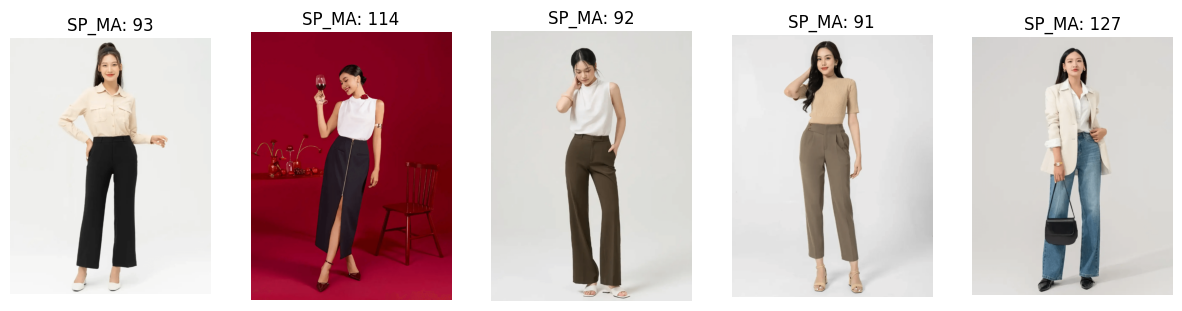

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(Image.open(query_image_path))
plt.axis('off')
plt.title("Ảnh truy vấn")
plt.show()

plt.figure(figsize=(15,5))
for i, (sp_id, img_path) in enumerate(results):
    plt.subplot(1,5,i+1)
    plt.imshow(Image.open(img_path))
    plt.axis('off')
    plt.title(f"SP_MA: {sp_id}")
plt.show()

In [ ]:
uploaded_query = files.upload()  # chọn ảnh truy vấn
query_image_path = list(uploaded_query.keys())[0]

def search_similar_products(query_image_path, top_k=5):
    clip_emb = get_clip_embedding(query_image_path)
    color_emb = get_dominant_color(query_image_path)
    query_emb = np.concatenate([clip_emb, color_emb]).astype('float32').reshape(1, -1)
    faiss.normalize_L2(query_emb)
    distances, indices = index.search(query_emb, top_k)

    results = []
    for i in indices[0]:
        sp_id = product_ids[i]
        img_path = product_id_to_representative_image[sp_id]
        results.append((sp_id, img_path))
    return results

results = search_similar_products(query_image_path, top_k=5)

Saving 4.jpg to 4.jpg


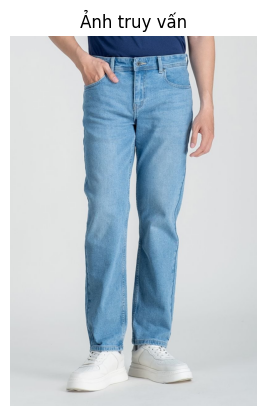

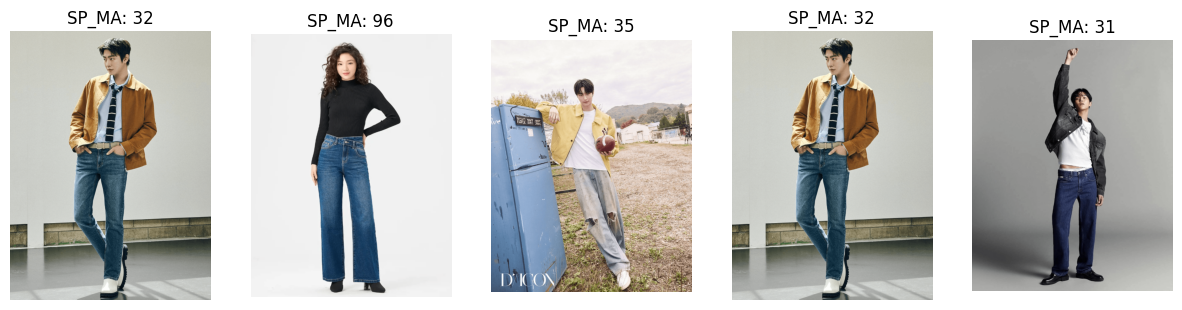

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(Image.open(query_image_path))
plt.axis('off')
plt.title("Ảnh truy vấn")
plt.show()

plt.figure(figsize=(15,5))
for i, (sp_id, img_path) in enumerate(results):
    plt.subplot(1,5,i+1)
    plt.imshow(Image.open(img_path))
    plt.axis('off')
    plt.title(f"SP_MA: {sp_id}")
plt.show()


In [ ]:
uploaded_query = files.upload()  # chọn ảnh truy vấn
query_image_path = list(uploaded_query.keys())[0]

def search_similar_products(query_image_path, top_k=5):
    clip_emb = get_clip_embedding(query_image_path)
    color_emb = get_dominant_color(query_image_path)
    query_emb = np.concatenate([clip_emb, color_emb]).astype('float32').reshape(1, -1)
    faiss.normalize_L2(query_emb)
    distances, indices = index.search(query_emb, top_k)

    results = []
    for i in indices[0]:
        sp_id = product_ids[i]
        img_path = product_id_to_representative_image[sp_id]
        results.append((sp_id, img_path))
    return results

results = search_similar_products(query_image_path, top_k=5)

Saving 5.PNG to 5.PNG


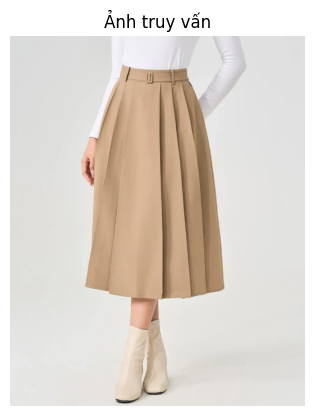

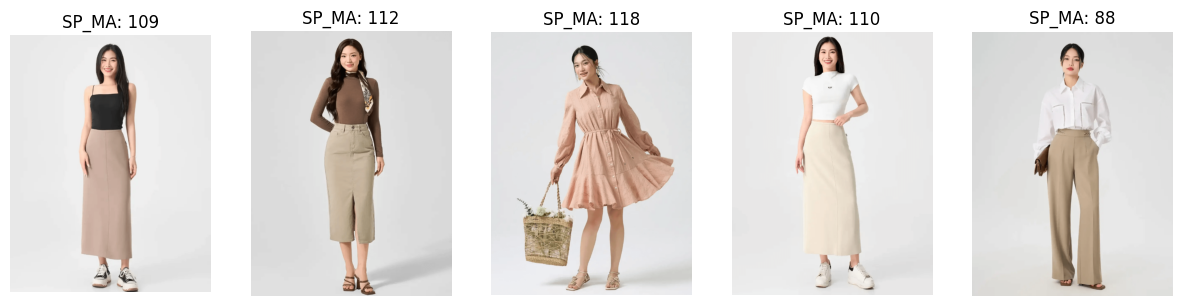

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(Image.open(query_image_path))
plt.axis('off')
plt.title("Ảnh truy vấn")
plt.show()

plt.figure(figsize=(15,5))
for i, (sp_id, img_path) in enumerate(results):
    plt.subplot(1,5,i+1)
    plt.imshow(Image.open(img_path))
    plt.axis('off')
    plt.title(f"SP_MA: {sp_id}")
plt.show()

In [ ]:
uploaded_query = files.upload()  # chọn ảnh truy vấn
query_image_path = list(uploaded_query.keys())[0]

def search_similar_products(query_image_path, top_k=5):
    clip_emb = get_clip_embedding(query_image_path)
    color_emb = get_dominant_color(query_image_path)
    query_emb = np.concatenate([clip_emb, color_emb]).astype('float32').reshape(1, -1)
    faiss.normalize_L2(query_emb)
    distances, indices = index.search(query_emb, top_k)

    results = []
    for i in indices[0]:
        sp_id = product_ids[i]
        img_path = product_id_to_representative_image[sp_id]
        results.append((sp_id, img_path))
    return results

results = search_similar_products(query_image_path, top_k=5)

Saving ao_somi_nam_ngan_tay_trang_tron_1.png to ao_somi_nam_ngan_tay_trang_tron_1.png


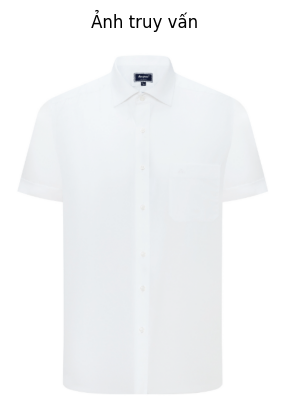

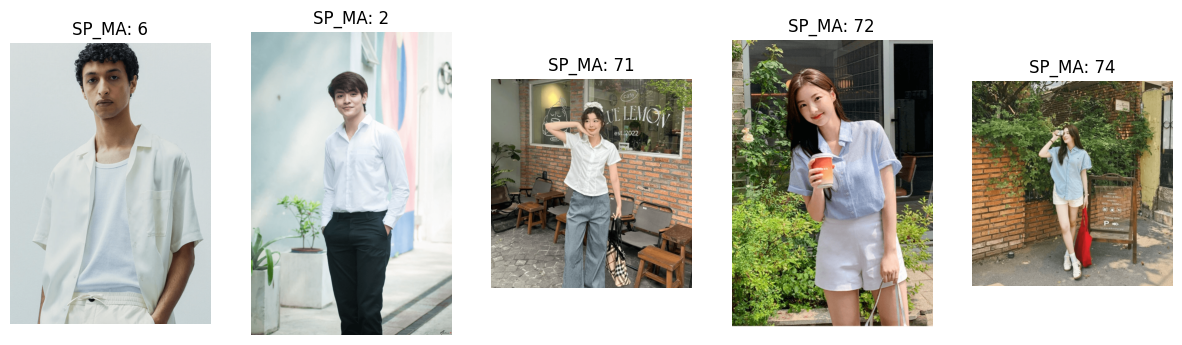

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(Image.open(query_image_path))
plt.axis('off')
plt.title("Ảnh truy vấn")
plt.show()

plt.figure(figsize=(15,5))
for i, (sp_id, img_path) in enumerate(results):
    plt.subplot(1,5,i+1)
    plt.imshow(Image.open(img_path))
    plt.axis('off')
    plt.title(f"SP_MA: {sp_id}")
plt.show()

In [ ]:
uploaded_query = files.upload()  # chọn ảnh truy vấn
query_image_path = list(uploaded_query.keys())[0]

def search_similar_products(query_image_path, top_k=5):
    clip_emb = get_clip_embedding(query_image_path)
    color_emb = get_dominant_color(query_image_path)
    query_emb = np.concatenate([clip_emb, color_emb]).astype('float32').reshape(1, -1)
    faiss.normalize_L2(query_emb)
    distances, indices = index.search(query_emb, top_k)

    results = []
    for i in indices[0]:
        sp_id = product_ids[i]
        img_path = product_id_to_representative_image[sp_id]
        results.append((sp_id, img_path))
    return results

results = search_similar_products(query_image_path, top_k=5)

Saving ao_somi_nu_hong_nhat_1.png to ao_somi_nu_hong_nhat_1.png


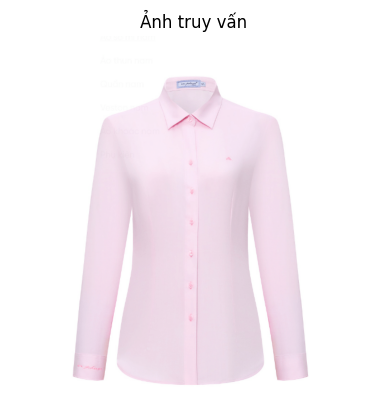

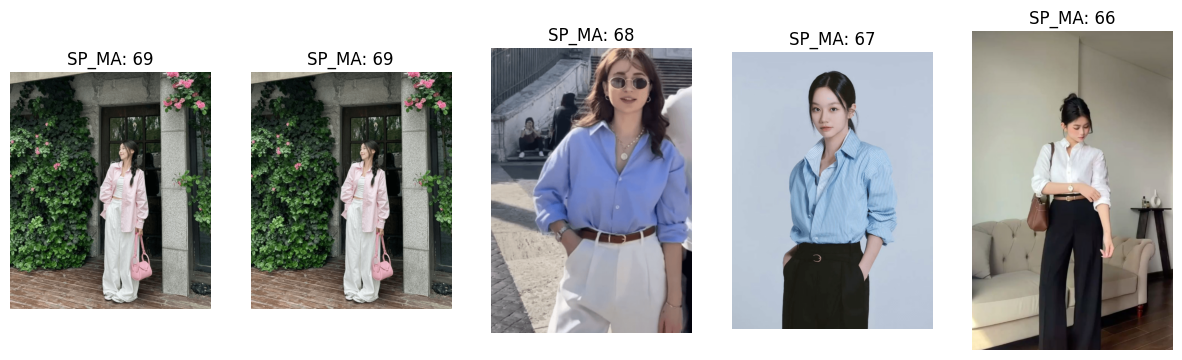

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(Image.open(query_image_path))
plt.axis('off')
plt.title("Ảnh truy vấn")
plt.show()

plt.figure(figsize=(15,5))
for i, (sp_id, img_path) in enumerate(results):
    plt.subplot(1,5,i+1)
    plt.imshow(Image.open(img_path))
    plt.axis('off')
    plt.title(f"SP_MA: {sp_id}")
plt.show()

In [ ]:
uploaded_query = files.upload()  # chọn ảnh truy vấn
query_image_path = list(uploaded_query.keys())[0]

def search_similar_products(query_image_path, top_k=5):
    clip_emb = get_clip_embedding(query_image_path)
    color_emb = get_dominant_color(query_image_path)
    query_emb = np.concatenate([clip_emb, color_emb]).astype('float32').reshape(1, -1)
    faiss.normalize_L2(query_emb)
    distances, indices = index.search(query_emb, top_k)

    results = []
    for i in indices[0]:
        sp_id = product_ids[i]
        img_path = product_id_to_representative_image[sp_id]
        results.append((sp_id, img_path))
    return results

results = search_similar_products(query_image_path, top_k=5)

Saving ao_thun_nu_trang_2.png to ao_thun_nu_trang_2.png


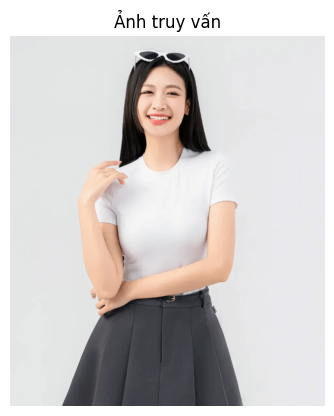

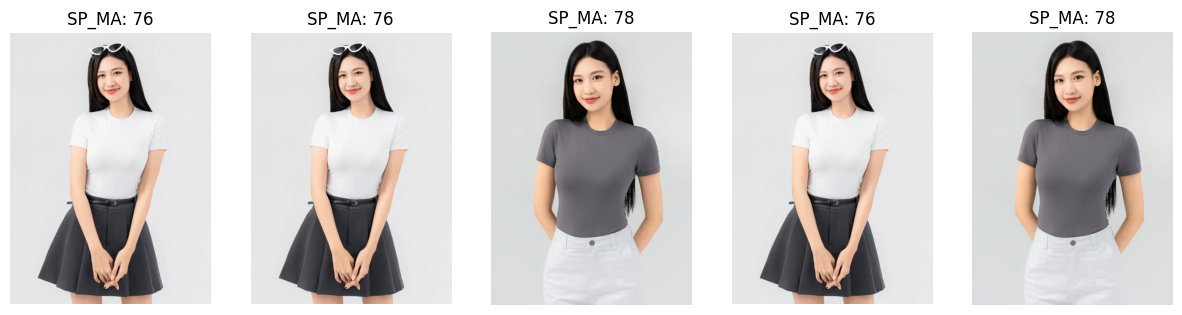

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(Image.open(query_image_path))
plt.axis('off')
plt.title("Ảnh truy vấn")
plt.show()

plt.figure(figsize=(15,5))
for i, (sp_id, img_path) in enumerate(results):
    plt.subplot(1,5,i+1)
    plt.imshow(Image.open(img_path))
    plt.axis('off')
    plt.title(f"SP_MA: {sp_id}")
plt.show()

In [ ]:
uploaded_query = files.upload()  # chọn ảnh truy vấn
query_image_path = list(uploaded_query.keys())[0]

def search_similar_products(query_image_path, top_k=5):
    clip_emb = get_clip_embedding(query_image_path)
    color_emb = get_dominant_color(query_image_path)
    query_emb = np.concatenate([clip_emb, color_emb]).astype('float32').reshape(1, -1)
    faiss.normalize_L2(query_emb)
    distances, indices = index.search(query_emb, top_k)

    results = []
    for i in indices[0]:
        sp_id = product_ids[i]
        img_path = product_id_to_representative_image[sp_id]
        results.append((sp_id, img_path))
    return results

results = search_similar_products(query_image_path, top_k=5)

Saving dam_cong_so_den_phoi_vien.png to dam_cong_so_den_phoi_vien.png


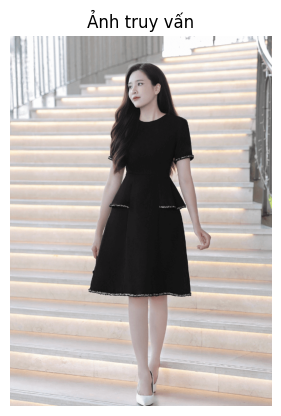

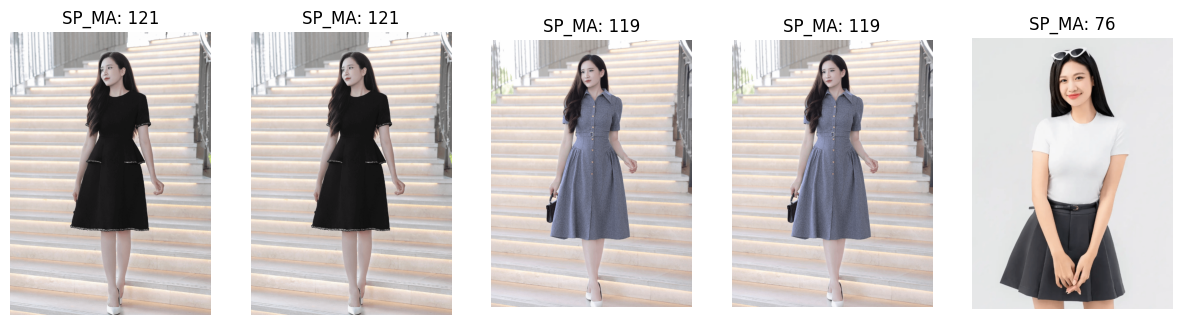

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(Image.open(query_image_path))
plt.axis('off')
plt.title("Ảnh truy vấn")
plt.show()

plt.figure(figsize=(15,5))
for i, (sp_id, img_path) in enumerate(results):
    plt.subplot(1,5,i+1)
    plt.imshow(Image.open(img_path))
    plt.axis('off')
    plt.title(f"SP_MA: {sp_id}")
plt.show()

In [ ]:
uploaded_query = files.upload()  # chọn ảnh truy vấn
query_image_path = list(uploaded_query.keys())[0]

def search_similar_products(query_image_path, top_k=5):
    clip_emb = get_clip_embedding(query_image_path)
    color_emb = get_dominant_color(query_image_path)
    query_emb = np.concatenate([clip_emb, color_emb]).astype('float32').reshape(1, -1)
    faiss.normalize_L2(query_emb)
    distances, indices = index.search(query_emb, top_k)

    results = []
    for i in indices[0]:
        sp_id = product_ids[i]
        img_path = product_id_to_representative_image[sp_id]
        results.append((sp_id, img_path))
    return results

results = search_similar_products(query_image_path, top_k=5)

Saving ao_thun_nam_do_2.png to ao_thun_nam_do_2.png


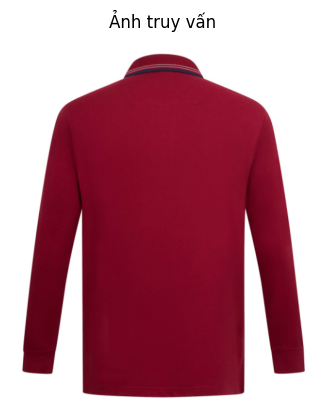

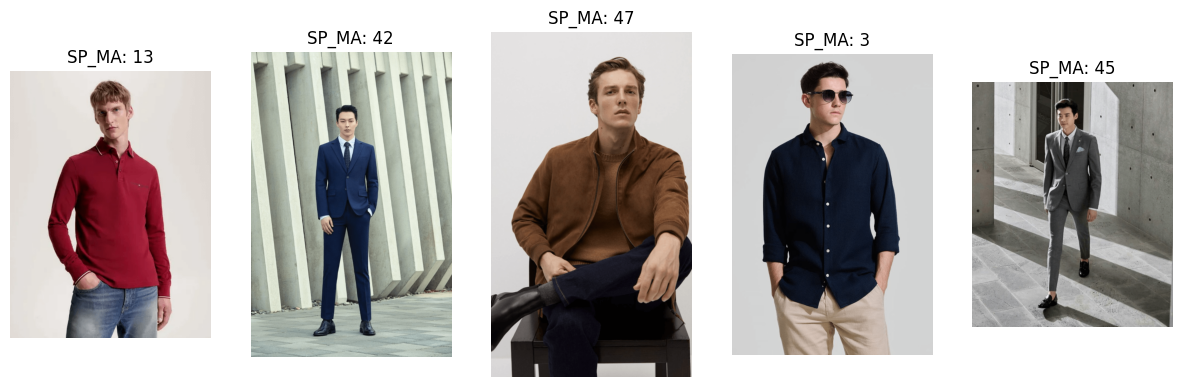

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(Image.open(query_image_path))
plt.axis('off')
plt.title("Ảnh truy vấn")
plt.show()

plt.figure(figsize=(15,5))
for i, (sp_id, img_path) in enumerate(results):
    plt.subplot(1,5,i+1)
    plt.imshow(Image.open(img_path))
    plt.axis('off')
    plt.title(f"SP_MA: {sp_id}")
plt.show()

In [ ]:
# ==========================================
# 1) Hàm tìm kiếm: trả về similarity + index + ảnh
# ==========================================

def search_similar_products(query_image_path, top_k=5):
    # Tạo embedding query
    clip_emb = get_clip_embedding(query_image_path)
    color_emb = get_dominant_color(query_image_path)
    query_emb = np.concatenate([clip_emb, color_emb]).astype('float32').reshape(1, -1)

    # Chuẩn hóa để cosine similarity hoạt động chính xác
    faiss.normalize_L2(query_emb)

    # Tìm kiếm bằng Inner Product (IP) ~ cosine similarity
    similarity, indices = index.search(query_emb, top_k)

    results = []
    for rank, i in enumerate(indices[0]):
        sp_id = product_ids[i]
        img_path = product_id_to_representative_image[sp_id]
        sim_score = similarity[0][rank]  # độ tương tự
        results.append((sp_id, img_path, sim_score, i))

    return similarity[0], indices[0], results


# ==========================================
# 2) Hàm hiển thị ảnh + similarity
# ==========================================

import matplotlib.pyplot as plt
from PIL import Image

def show_results_with_similarity(query_image_path, results):
    top_k = len(results)
    plt.figure(figsize=(4 * top_k, 10))

    # --- Ảnh truy vấn ---
    plt.subplot(2, top_k, 1)
    plt.imshow(Image.open(query_image_path))
    plt.axis("off")
    plt.title("Ảnh truy vấn", fontsize=18)

    # --- Ảnh kết quả + similarity ---
    for i, (sp_id, img_path, sim_score, idx) in enumerate(results):
        plt.subplot(2, top_k, top_k + i + 1)
        plt.imshow(Image.open(img_path))
        plt.axis("off")
        plt.title(f"similarity: {sim_score:.4f}\nindex: {idx}", fontsize=14)

    plt.tight_layout()
    plt.show()


# ==========================================
# 3) Chạy thử toàn bộ
# ==========================================

uploaded_query = files.upload()  # chọn ảnh truy vấn
query_image_path = list(uploaded_query.keys())[0]

# Tìm kiếm
similarity, indices, results = search_similar_products(query_image_path, top_k=5)

# In ra giống hình demo (similarity + index)
print("Similarity:", similarity)
print("Indices:", indices)

# Hiển thị hình
show_results_with_similarity(query_image_path, results)


Saving 7.jpg to 7 (1).jpg
Distances: [0.98000544 0.97716624 0.9763399  0.97433734 0.97425604]
Indices: [471 462 470 439 465]


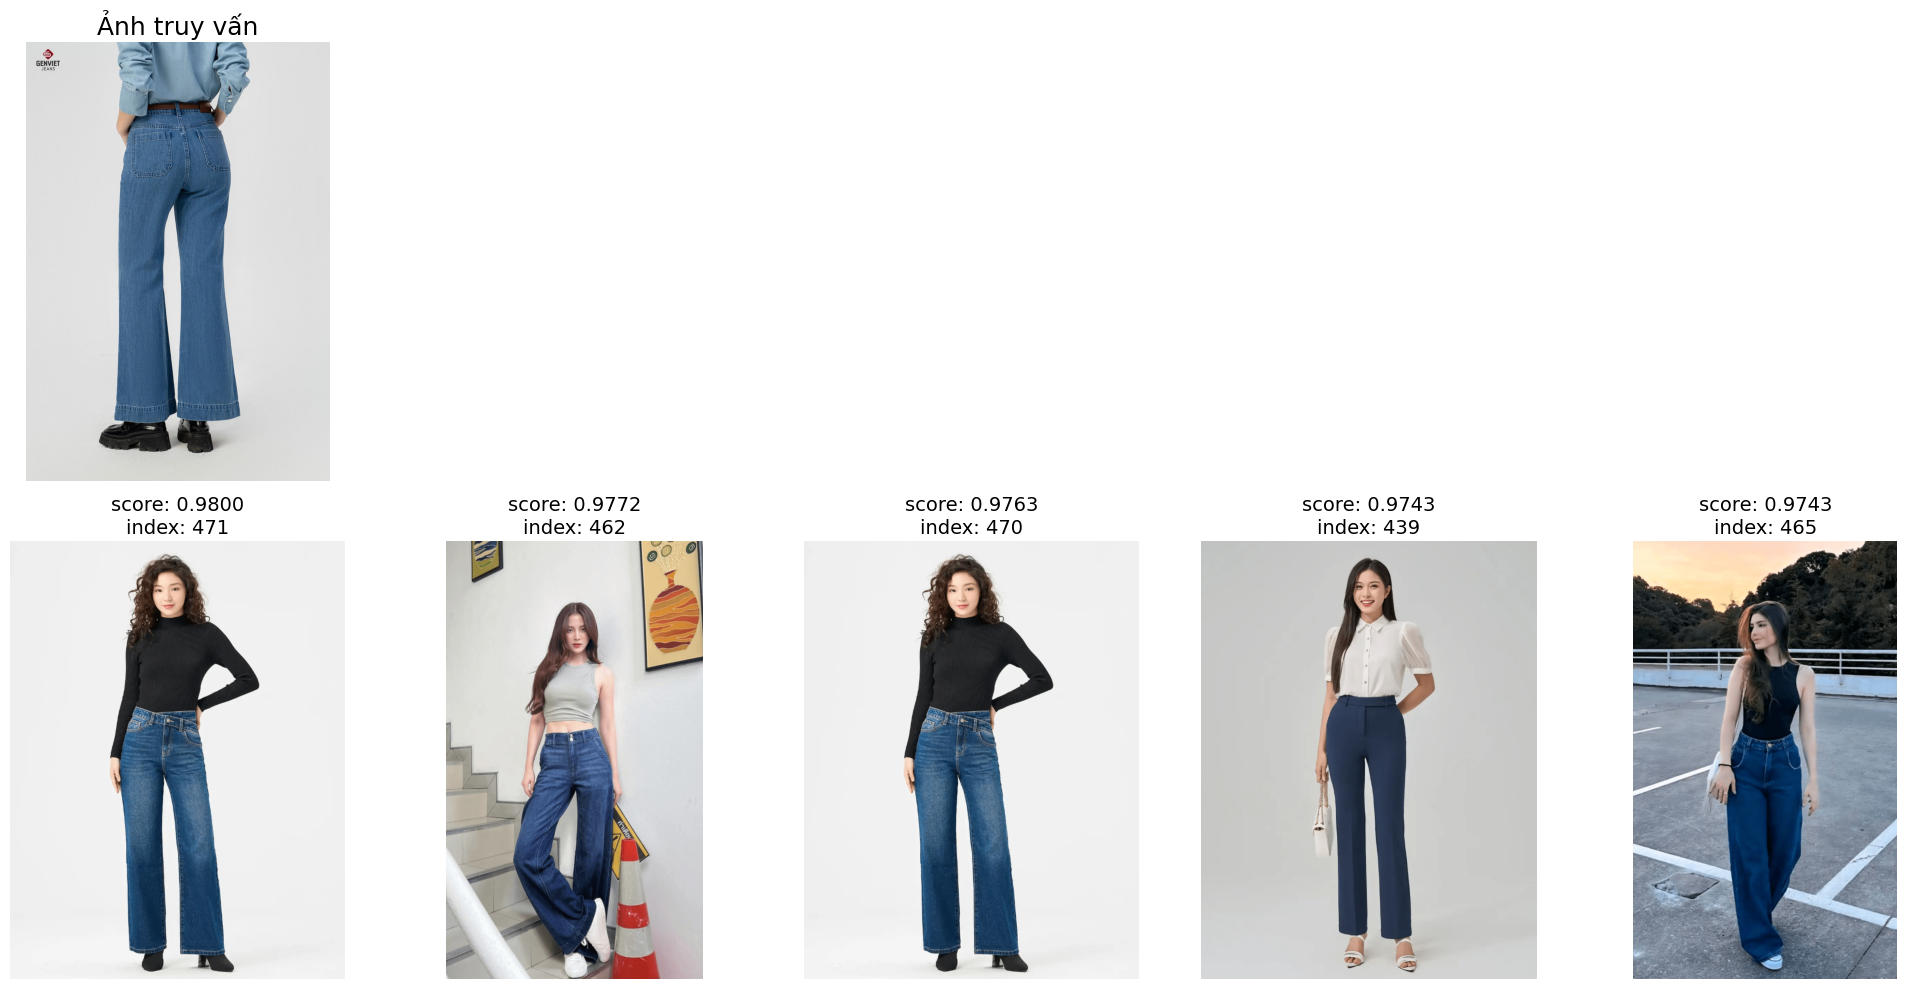

In [ ]:
# ==========================================
# 1) Hàm tìm kiếm: trả về distance + index + ảnh
# ==========================================

def search_similar_products(query_image_path, top_k=5):
    # Tạo embedding query
    clip_emb = get_clip_embedding(query_image_path)
    color_emb = get_dominant_color(query_image_path)
    query_emb = np.concatenate([clip_emb, color_emb]).astype('float32').reshape(1, -1)

    # Chuẩn hóa để tìm cosine similarity
    faiss.normalize_L2(query_emb)

    # Tìm kiếm
    distances, indices = index.search(query_emb, top_k)

    results = []
    for rank, i in enumerate(indices[0]):
        sp_id = product_ids[i]
        img_path = product_id_to_representative_image[sp_id]
        score = distances[0][rank]  # độ tương tự
        results.append((sp_id, img_path, score, i))

    return distances[0], indices[0], results


# ==========================================
# 2) Hàm hiển thị hình đẹp như demo Lotus
# ==========================================

import matplotlib.pyplot as plt
from PIL import Image

def show_results_with_score(query_image_path, results):
    top_k = len(results)
    plt.figure(figsize=(4 * top_k, 10))

    # --- Ảnh truy vấn ---
    plt.subplot(2, top_k, 1)
    plt.imshow(Image.open(query_image_path))
    plt.axis("off")
    plt.title("Ảnh truy vấn", fontsize=18)

    # --- Ảnh kết quả + score ---
    for i, (sp_id, img_path, score, idx) in enumerate(results):
        plt.subplot(2, top_k, top_k + i + 1)
        plt.imshow(Image.open(img_path))
        plt.axis("off")
        plt.title(f"score: {score:.4f}\nindex: {idx}", fontsize=14)

    plt.tight_layout()
    plt.show()


# ==========================================
# 3) Chạy thử
# ==========================================

uploaded_query = files.upload()  # chọn ảnh truy vấn
query_image_path = list(uploaded_query.keys())[0]

# Tìm kiếm
distances, indices, results = search_similar_products(query_image_path, top_k=5)

# In ra distance + index giống ảnh ví dụ bạn muốn
print("Distances:", distances)
print("Indices:", indices)

# Hiển thị hình
show_results_with_score(query_image_path, results)


Saving giay_the_thao_nam_trang_3.png to giay_the_thao_nam_trang_3.png
Distances: [1.         0.95886356 0.9369057  0.93054193 0.9303444 ]
Indices: [278 275 671 665 276]


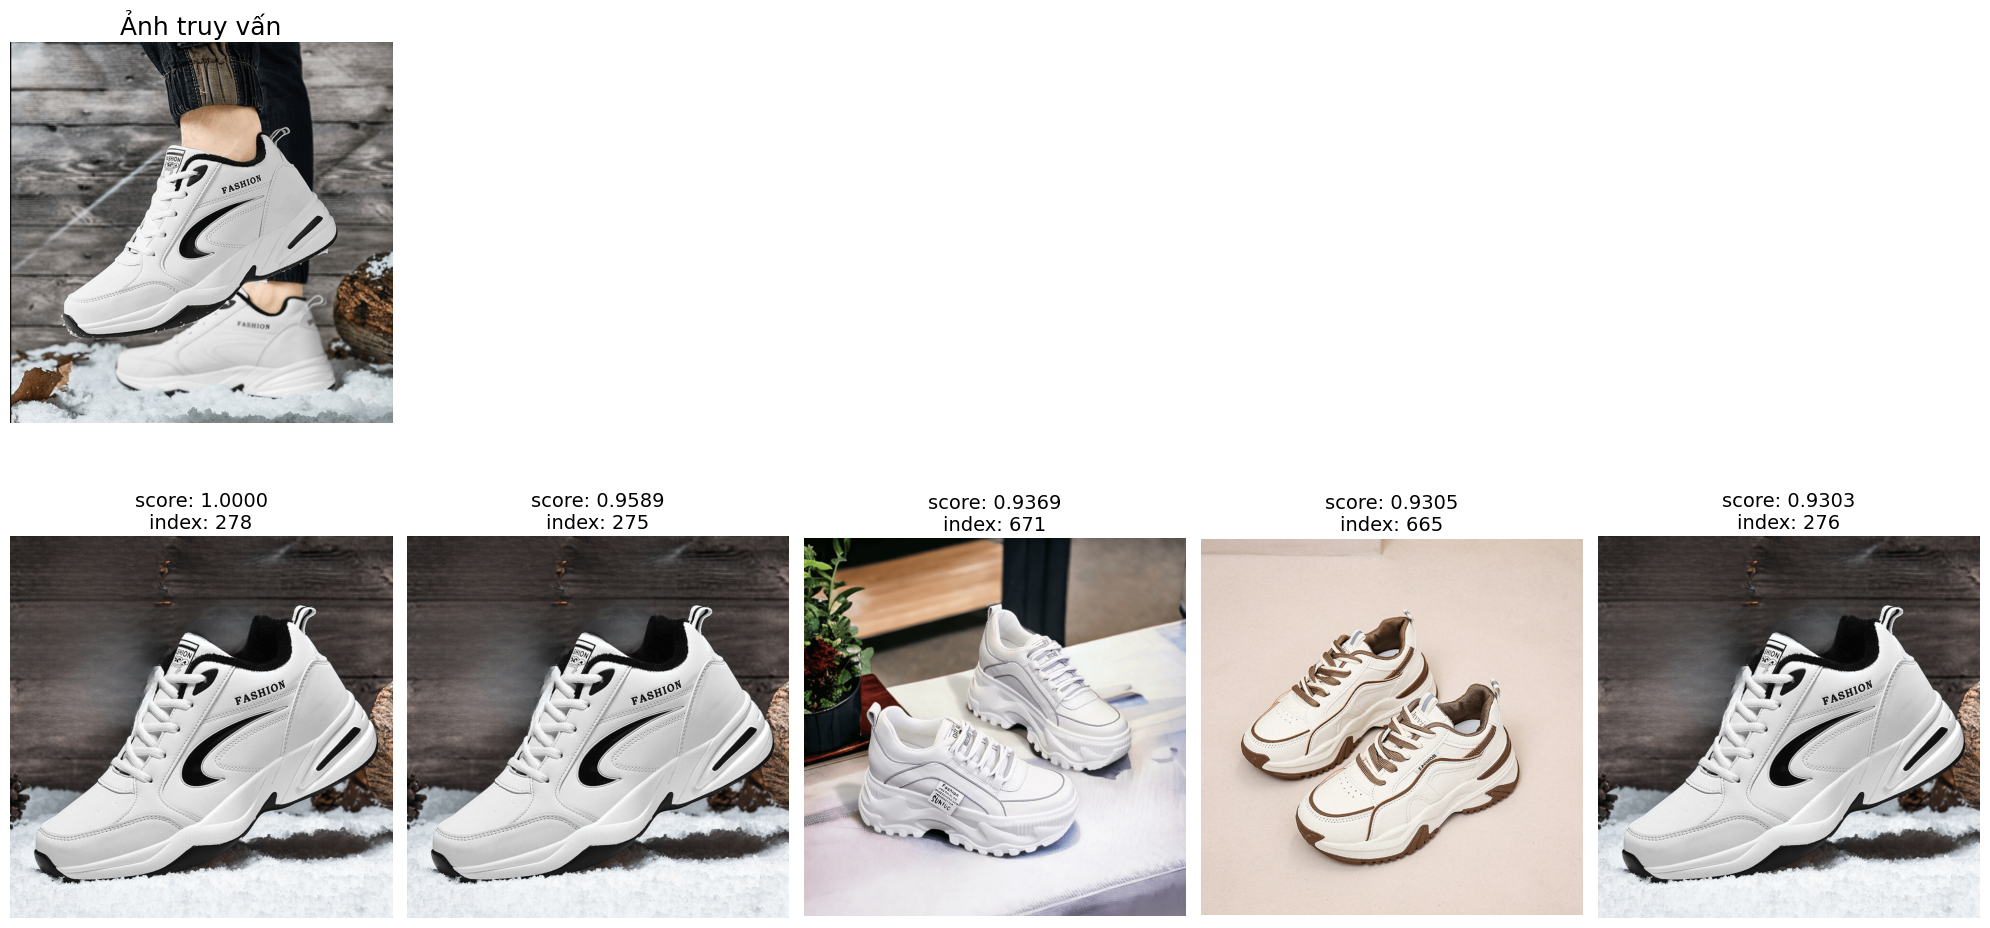

In [ ]:
# ==========================================
# 1) Hàm tìm kiếm: trả về distance + index + ảnh
# ==========================================

def search_similar_products(query_image_path, top_k=5):
    # Tạo embedding query
    clip_emb = get_clip_embedding(query_image_path)
    color_emb = get_dominant_color(query_image_path)
    query_emb = np.concatenate([clip_emb, color_emb]).astype('float32').reshape(1, -1)

    # Chuẩn hóa để tìm cosine similarity
    faiss.normalize_L2(query_emb)

    # Tìm kiếm
    distances, indices = index.search(query_emb, top_k)

    results = []
    for rank, i in enumerate(indices[0]):
        sp_id = product_ids[i]
        img_path = product_id_to_representative_image[sp_id]
        score = distances[0][rank]  # độ tương tự
        results.append((sp_id, img_path, score, i))

    return distances[0], indices[0], results


# ==========================================
# 2) Hàm hiển thị hình đẹp như demo Lotus
# ==========================================

import matplotlib.pyplot as plt
from PIL import Image

def show_results_with_score(query_image_path, results):
    top_k = len(results)
    plt.figure(figsize=(4 * top_k, 10))

    # --- Ảnh truy vấn ---
    plt.subplot(2, top_k, 1)
    plt.imshow(Image.open(query_image_path))
    plt.axis("off")
    plt.title("Ảnh truy vấn", fontsize=18)

    # --- Ảnh kết quả + score ---
    for i, (sp_id, img_path, score, idx) in enumerate(results):
        plt.subplot(2, top_k, top_k + i + 1)
        plt.imshow(Image.open(img_path))
        plt.axis("off")
        plt.title(f"score: {score:.4f}\nindex: {idx}", fontsize=14)

    plt.tight_layout()
    plt.show()


# ==========================================
# 3) Chạy thử
# ==========================================

uploaded_query = files.upload()  # chọn ảnh truy vấn
query_image_path = list(uploaded_query.keys())[0]

# Tìm kiếm
distances, indices, results = search_similar_products(query_image_path, top_k=5)

# In ra distance + index giống ảnh ví dụ bạn muốn
print("Distances:", distances)
print("Indices:", indices)

# Hiển thị hình
show_results_with_score(query_image_path, results)

In [ ]:
# ==========================================
# 1) Hàm tìm kiếm: trả về similarity + index + ảnh
# ==========================================

def search_similar_products(query_image_path, top_k=5):
    # Tạo embedding query
    clip_emb = get_clip_embedding(query_image_path)
    color_emb = get_dominant_color(query_image_path)
    query_emb = np.concatenate([clip_emb, color_emb]).astype('float32').reshape(1, -1)

    # Normalize vì sử dụng cosine (inner product)
    faiss.normalize_L2(query_emb)

    # Tìm kiếm
    sims, indices = index.search(query_emb, top_k)   # sims = cosine similarity

    results = []
    for rank, i in enumerate(indices[0]):
        sp_id = product_ids[i]
        img_path = product_id_to_representative_image[sp_id]
        similarity = sims[0][rank]  # đổi tên
        results.append((sp_id, img_path, similarity, i))

    return sims[0], indices[0], results


In [ ]:
# ==========================================
# 2) Hàm hiển thị hình với similarity
# ==========================================

import matplotlib.pyplot as plt
from PIL import Image

def show_results_with_score(query_image_path, results):
    top_k = len(results)
    plt.figure(figsize=(4 * top_k, 10))

    # Ảnh truy vấn
    plt.subplot(2, top_k, 1)
    plt.imshow(Image.open(query_image_path))
    plt.axis("off")
    plt.title("Ảnh truy vấn", fontsize=18)

    # Ảnh kết quả
    for i, (sp_id, img_path, similarity, idx) in enumerate(results):
        plt.subplot(2, top_k, top_k + i + 1)
        plt.imshow(Image.open(img_path))
        plt.axis("off")
        plt.title(f"similarity: {similarity:.4f}\nindex: {idx}", fontsize=14)

    plt.tight_layout()
    plt.show()


Saving 7.jpg to 7 (2).jpg
Similarities: [0.98000544 0.97716624 0.9763399  0.97433734 0.97425604]
Indices: [471 462 470 439 465]


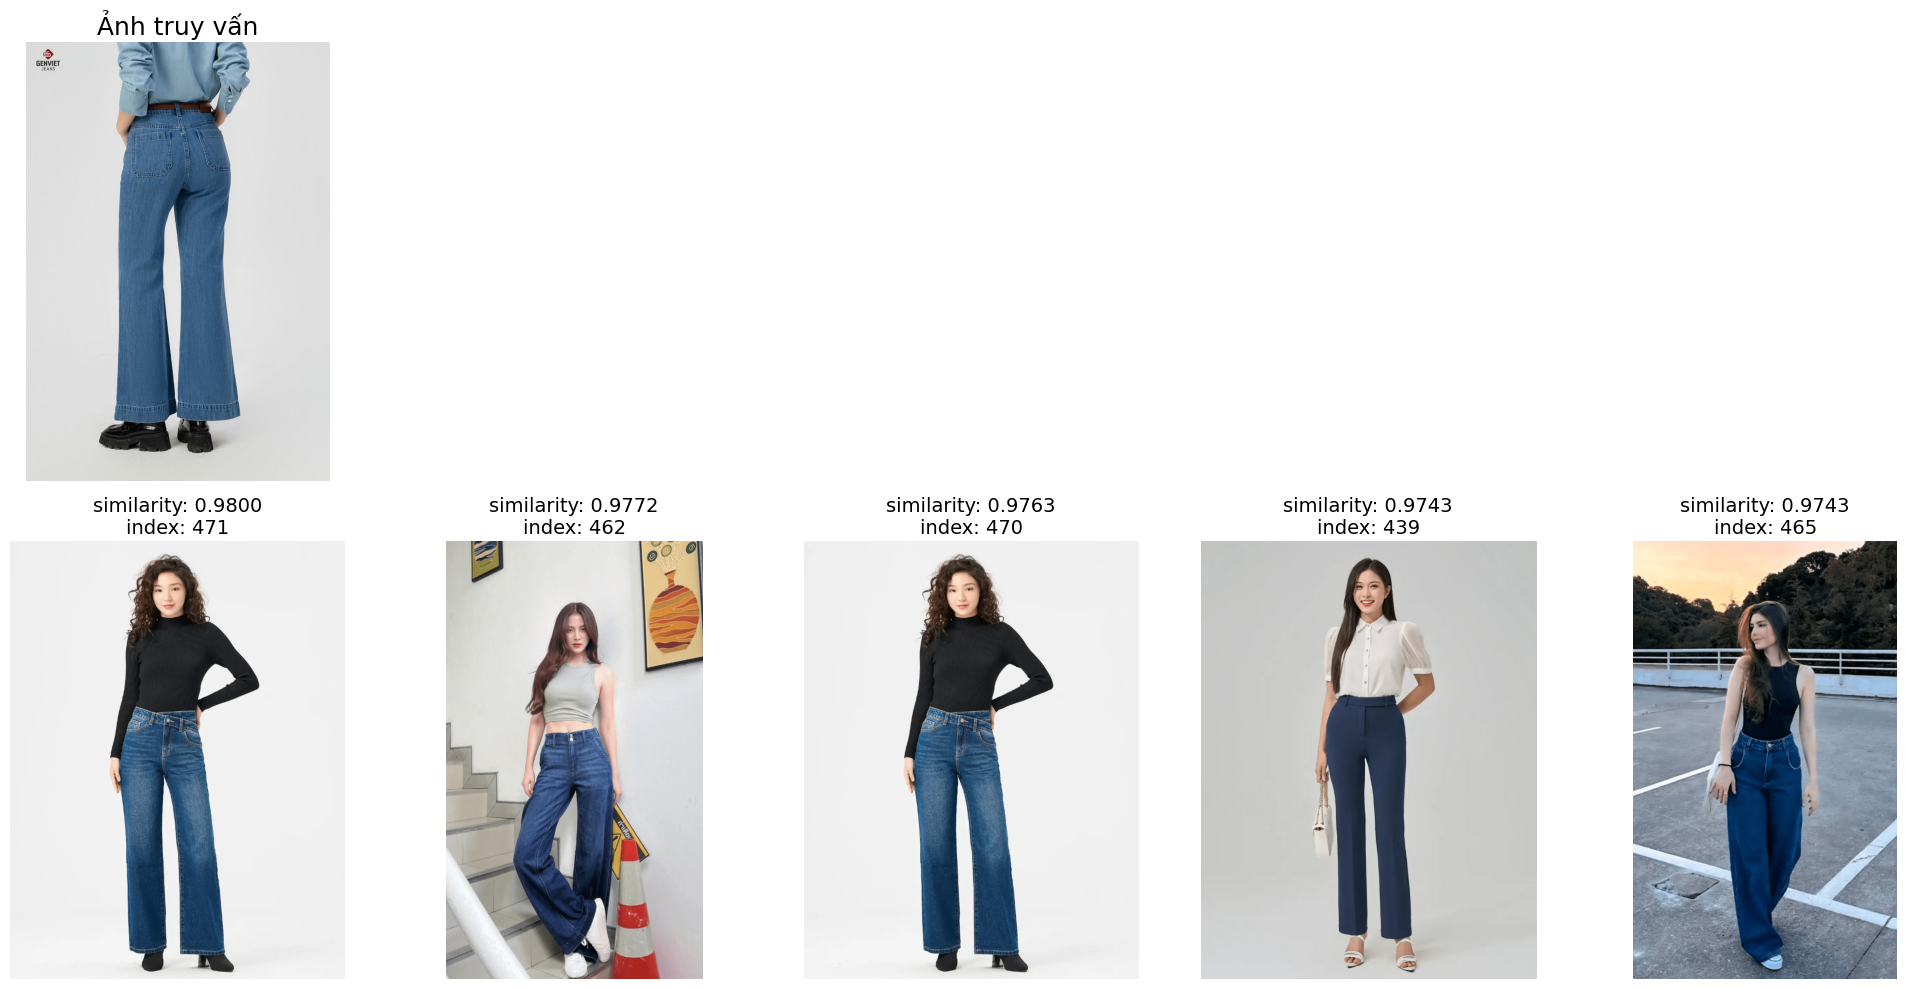

In [ ]:
# ==========================================
# 3) Chạy thử
# ==========================================

uploaded_query = files.upload()
query_image_path = list(uploaded_query.keys())[0]

# Tìm kiếm
similarities, indices, results = search_similar_products(query_image_path, top_k=5)

# In ra giống hình mẫu bạn muốn
print("Similarities:", similarities)
print("Indices:", indices)

# Hiển thị hình
show_results_with_score(query_image_path, results)


Saving quan_short_nam_kem_1.png to quan_short_nam_kem_1.png
Similarities: [0.99999994 0.9928121  0.98753566 0.98700154 0.98584753]
Indices: [176 177 142 108 141]


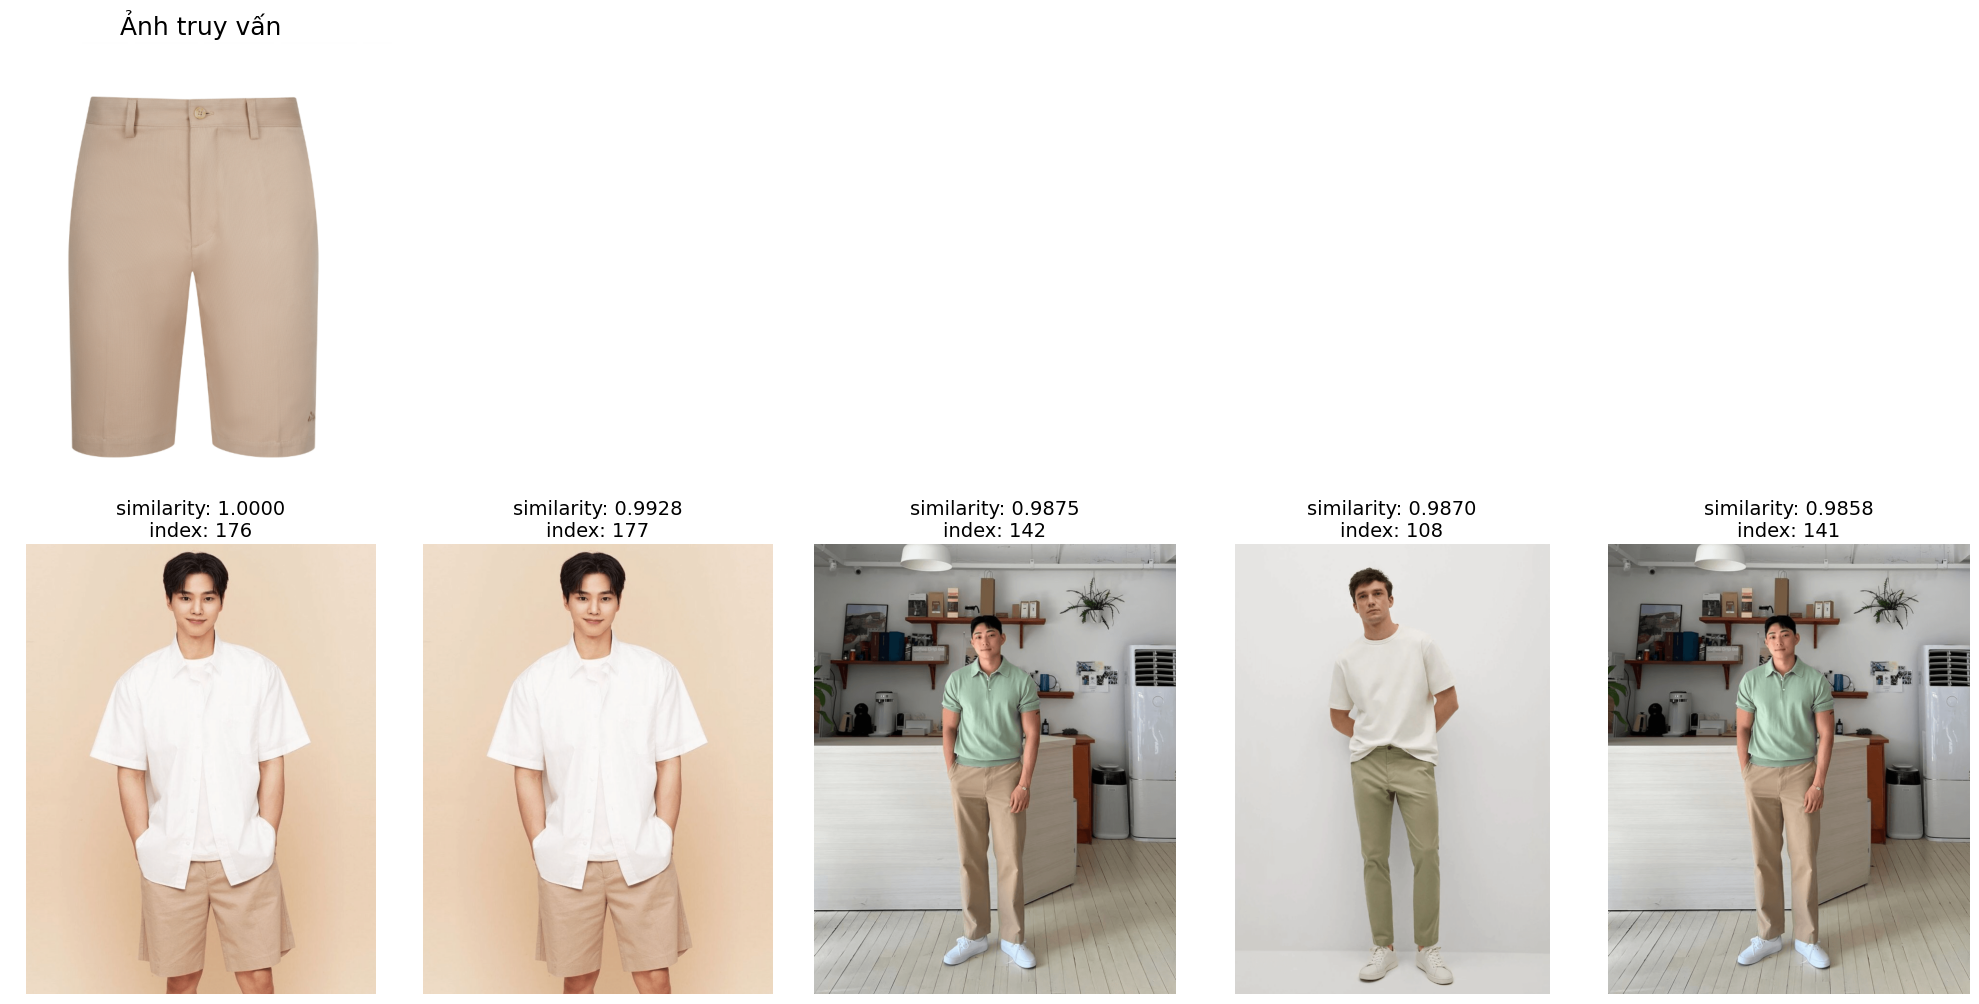

In [ ]:
# ==========================================
# 3) Chạy thử
# ==========================================

uploaded_query = files.upload()
query_image_path = list(uploaded_query.keys())[0]

# Tìm kiếm
similarities, indices, results = search_similar_products(query_image_path, top_k=5)

# In ra giống hình mẫu bạn muốn
print("Similarities:", similarities)
print("Indices:", indices)

# Hiển thị hình
show_results_with_score(query_image_path, results)